In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse

15253
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

colors_ = ["blue", "red", "green", "gray", "black"]

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

for i in range(10):
    plt.close()

In [11]:
# --- Global parameters ---
# path_coef_ = "../QuCF/tests/compute-angles/inversion"
# filename_ = "compute.hdf5"

path_coef_ = "../QuCF/tests/compute-angles/LCHS_weights"
filename_ = "kmax80_eps5.hdf5"

In [12]:
# ----------------------------------------------------------
# --- Read the results from the computation of angles ---
# ----------------------------------------------------------
mix.reload_module(mix)

full_filename = path_coef_ + "/" + filename_

dd = {}
print("Reading angles from the file \n{:s}".format(full_filename))
with h5py.File(full_filename, "r") as f:
    gr = f["basic"]
    dd["date-of-simulation"] = gr["date-of-simulation"][()].decode("utf-8")
    
    dd["function-type"]       = gr["function-type"][()].decode("utf-8")
    dd["function-parity"]     = gr["function-parity"][()]
    dd["function-parameter"]  = gr["function-parameter"][()]
    dd["abs-error"]           = gr["abs-error"][()]
    dd["factor-norm"]         = gr["factor-norm"][()]
    
    gr = f["results"]
    dd["x"] = np.array(gr["x"]) # Chebyschev roots (nodes);
    dd["pol-coefs"] = np.array(gr["pol-coefs"]) # the polynomial constructed using coefficients;
    dd["pol-angles"] = np.array(gr["pol-angles"]) # the polynomial constructed using computed angles;
    dd["phis"] = np.array(gr["phis"])

# print some basic results:
print("when simulated: ", dd["date-of-simulation"])
print()
print("function-type: \t\t{:s}".format(dd["function-type"]))
print("function-parity: \t\t{:d}".format(dd["function-parity"]))
print("param: \t\t\t{:f}".format(dd["function-parameter"]))
print("absolute error: \t{:0.3e}".format(dd["abs-error"]))
print("norm. factor: \t\t{:0.3e}".format(dd["factor-norm"]))
print("Number of angles: \t{:d}".format(len(dd["phis"])))

# --- Construct the target function and renormalize the polynomial approximation ---
Nx = len(dd["x"])
pol_coefs_  = np.zeros(Nx)
pol_angles_ = np.zeros(Nx)
target_ref_      = np.zeros(Nx)
target_ref_xnew_ = np.zeros(Nx)
x_new = np.zeros(np.size(dd["x"]))
int_range = []

    
if(dd["function-type"] == "inversion"):
    coef_norm   = dd["factor-norm"] / dd["function-parameter"]
    pol_coefs_  = dd["pol-coefs"]  
    pol_angles_ = dd["pol-angles"] 
    target_ref_ = 1./dd["x"] * coef_norm
    
    x_new = np.linspace(1./dd["function-parameter"], 1.0, Nx)
    target_ref_xnew_ = 1./x_new * coef_norm
    
    int_range = np.where(dd["x"] >= 1./ dd["function-parameter"])[0]
    
    
if(dd["function-type"] == "sqrt_inv_arcsin2"):
    coef_norm   = dd["factor-norm"]
    pol_coefs_  = dd["pol-coefs"]  
    pol_angles_ = dd["pol-angles"] 
    
    target_ref_ = coef_norm / np.sqrt(1 + np.arcsin(dd["x"])**2 * dd["function-parameter"]**2)
    
    
    int_range = np.array(range(len(dd["x"])))
    

# Recheck some parameters:
# max_renorm_abs_error = np.max(np.abs(target_ref_[int_range] - pol_angles_[int_range]))
# max_renorm_abs_error = np.max(np.abs(pol_coefs_[int_range] - pol_angles_[int_range]))
# max_renorm_abs_error = np.max(np.abs(pol_coefs_[int_range] - target_ref_[int_range]))
print()
print("max. absolute error: \t{:0.3e}".format(max_renorm_abs_error))

Reading angles from the file 
../QuCF/tests/compute-angles/LCHS_weights/kmax80_eps5.hdf5
when simulated:  12-08-2023 22:25:53

function-type: 		sqrt_inv_arcsin2
function-parity: 		0
param: 			80.000000
absolute error: 	1.075e-05
norm. factor: 		9.800e-01
Number of angles: 	799

max. absolute error: 	2.504e-05


<IPython.core.display.Javascript object>


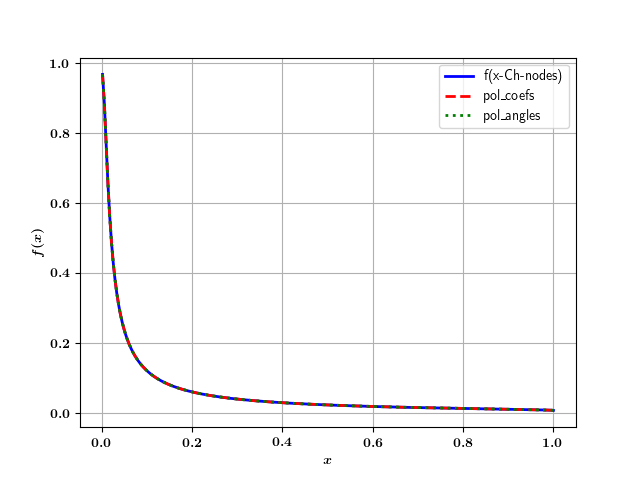

In [13]:
# ----------------------------------------------------------------------
# --- Plot the constructed target polynomial ---
# ----------------------------------------------------------------------
mix.reload_module(mix)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dd["x"], target_ref_, color='b', linewidth = 2, linestyle='-',  label = "f(x-Ch-nodes)")
ax.plot(dd["x"],  pol_coefs_, color='r', linewidth = 2, linestyle='--', label = "pol_coefs")
ax.plot(dd["x"], pol_angles_, color='g', linewidth = 2, linestyle=':', label = "pol_angles")
plt.xlabel('$x$')
plt.ylabel("$f(x)$")
ax.legend()
plt.grid(True)
plt.show()

if(dd["function-type"] == "inversion"):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_new,   target_ref_xnew_, color='b', linewidth = 2, linestyle='-',  label = "f(x-new)")
    ax.plot(dd["x"],       pol_coefs_, color='r', linewidth = 2, linestyle='--', label = "pol_coefs")
    ax.plot(dd["x"],      pol_angles_, color='g', linewidth = 2, linestyle=':', label = "pol_angles")
    plt.xlabel('$x$')
    plt.ylabel("$f(x)$")
    ax.legend()
    plt.grid(True)
    plt.show()